In [53]:
import torch 
from torch import nn 
import torch.nn.functional as F 
import torchvision
from torchvision import transforms
from torch.optim import AdamW, Adagrad, RMSprop
from torch.utils.data import DataLoader

from sklearn.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from PIL import Image

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda'

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [76]:
train_data = torchvision.datasets.CIFAR100(root="/kaggle/working/", train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR100(root="/kaggle/working/", train=False, download=True, transform=transform)

100%|██████████| 169001437/169001437 [00:03<00:00, 49238739.37it/s]


Extracting /kaggle/working/cifar-100-python.tar.gz to /kaggle/working/
Files already downloaded and verified


In [79]:
class_names = train_data.classes

In [81]:
def output(limit, dataset):
    count = 0
    
    for x, y in dataset:
        x = x.permute(1, 2, 0)
        plt.imshow(x)
        plt.title(class_names[int(y)])
        plt.show()
        count += 1
    
        if count >= limit:
            break
        

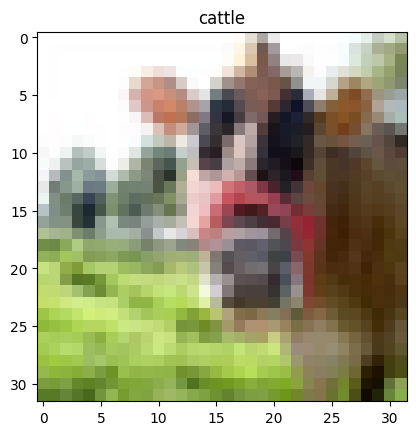

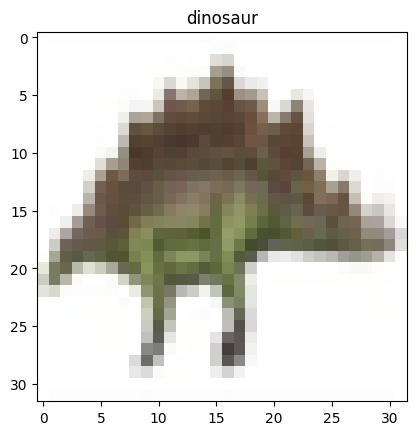

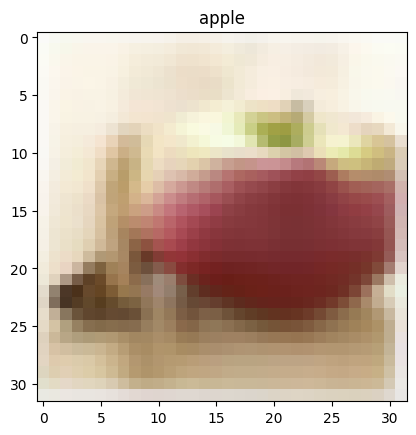

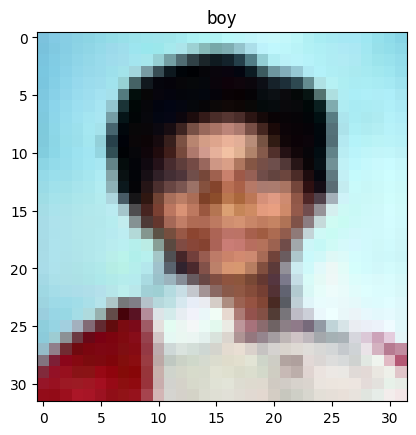

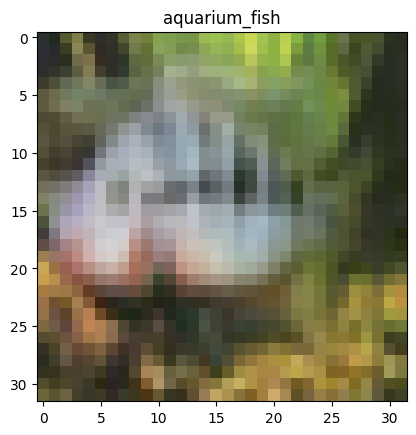

In [82]:
output(5, train_data)

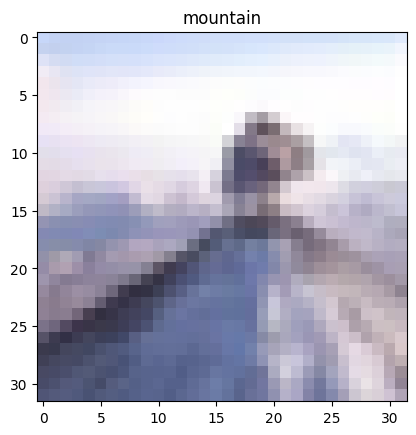

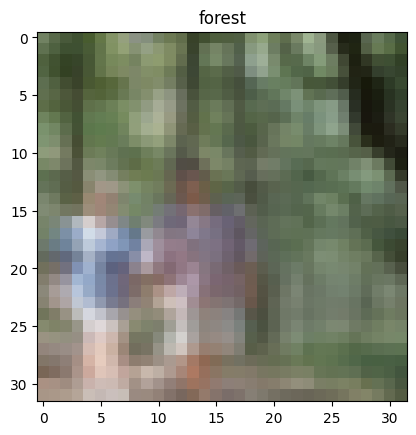

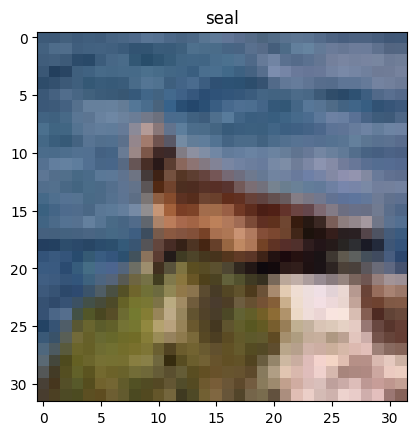

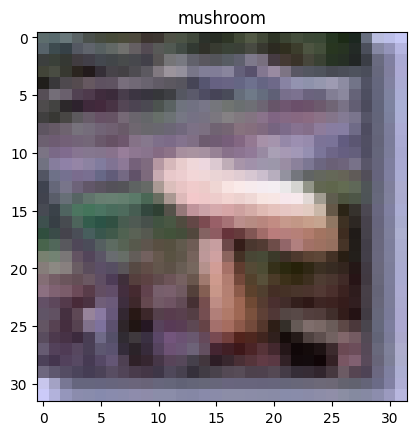

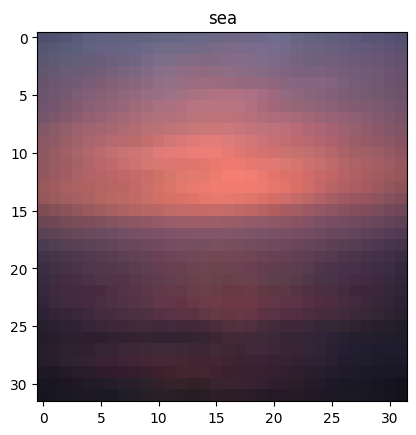

In [83]:
output(5, test_data)

In [84]:
len(train_data)

50000

In [86]:
train_dl = DataLoader(train_data, batch_size=32, generator=torch.Generator(device="cpu"))
val_dl = DataLoader(test_data, batch_size=32, generator=torch.Generator(device="cpu"))

In [87]:
class SkipBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool = False, upsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1)

        self.add_conv = nn.Sequential()

        if in_channels != out_channels:
            self.add_conv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)

        if pool == True:
            self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        else:
            self.pool = None


        if upsample == True:
            self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        else:
            self.upsample = None
            

    def forward(self, x):
        out = self.conv1(x)
        add_out = self.add_conv(x)

        
        out = F.relu(out)
        out = self.conv2(out)
        out += add_out

        out = F.relu(out)

        if self.pool:
            out = self.pool(out)

        if self.upsample:
            out = self.upsample(out)

        return out  

In [88]:
block = SkipBlock(1, 32)
tensor = torch.rand(1, 224, 224)

out = block(tensor)
out.shape

torch.Size([32, 224, 224])

In [89]:
class SkipTransposeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False):
        super().__init__()

        self.transpose1 = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size = 3, padding = 1)
        self.transpose2 = nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels, kernel_size = 3, padding = 1)

        self.add_transpose = nn.Sequential()

        if in_channels != out_channels:
            self.add_transpose = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size = 3, padding = 1)

        if upsample == True:
            self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        else:
            self.upsample = None

    def forward(self, x):
        out = self.transpose1(x)
        add_out =  self.add_transpose(x)

        out = F.relu(out)

        out = self.transpose2(out)
        out += add_out

        if self.upsample:
            out = self.upsample(out)

        out = F.relu(out)

        return out
        

In [90]:
block = SkipTransposeBlock(32, 3)
tensor = torch.rand(32, 224, 224)

out = block(tensor)
out.shape

torch.Size([3, 224, 224])

In [91]:
class SEBlock(nn.Module):
    def __init__(self, C, r):
        super().__init__()

        self.aap = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(C, C//r)
        self.linear2 = nn.Linear(C//r, C)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.aap(x)
        out = self.flatten(out)

        out = self.linear1(out)
        out = self.relu(out)

        out = self.linear2(out)
        out = self.sigmoid(out)

        out = out[:, :, None, None]
        res = out * x

        return res

In [92]:
block = SEBlock(32, 16)
tensor = torch.rand(1, 32, 224, 224)

out = block(tensor)
out.shape

torch.Size([1, 32, 224, 224])

In [93]:
class Painter(nn.Module):
    def __init__(self):
        super().__init__()

        # self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size=3, padding=1)
        # 1, 224, 224
        self.skip_block1 = SkipBlock(1, 32, pool = False)
        self.se_block1_1 = SEBlock(32, 16)
        # 32, 112, 112
        self.skip_block2 = SkipBlock(32, 64, pool = False)
        # 64, 64, 64
        self.skip_block3 = SkipBlock(64, 128, pool = False)
        self.se_block1_3 = SEBlock(128, 16)
        # 128, 32, 32
        self.up_conv1 = nn.ConvTranspose2d(in_channels = 128, out_channels = 128, kernel_size=7, padding=3)
        # 128, 32, 32
        self.up_conv_block2 = SkipTransposeBlock(256, 64, upsample = False)
        # 64, 64, 64
        self.up_conv_block3 = SkipTransposeBlock(128, 32, upsample = False)
        # 32, 112, 112
        self.up_conv_block4 = SkipTransposeBlock(64, 3, upsample = False)
        # 3, 224, 224
        



    def forward(self, x):
        # 1, 224, 224
        out1 = self.skip_block1(x)
        out1 = self.se_block1_1(out1)
        # 32, 112, 112
        out2 = self.skip_block2(out1)
        # 64, 64, 64
        out3 = self.skip_block3(out2)
        out3 = self.se_block1_3(out3)
        # 128, 32, 32
        
        up4 = self.up_conv1(out3)
        up4 = F.leaky_relu(up4)
        # 128, 32, 32

        up4 = torch.concat([out3, up4], dim=1)
        # 256, 32, 32
        up3 = self.up_conv_block2(up4)
        # 64, 64, 64

        up3 = torch.concat([out2, up3], dim=1)
        # 128, 64, 64
        up2 = self.up_conv_block3(up3)
        # 32, 112, 112

        up2 = torch.concat([out1, up2], dim=1)
        # 64, 112, 112
        res = self.up_conv_block4(up2)
        # 3, 224, 224

        return res 

    def predict(self, x):
        self.eval()
        x = x.to(device)

        if len(x.shape) == 3:
            x = x.unsqueeze(0)

        with torch.no_grad():
            out = self.forward(x)

        return out 

    
    
        

In [94]:
model = Painter()
model.to(device)

Painter(
  (skip_block1): SkipBlock(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (add_conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (se_block1_1): SEBlock(
    (aap): AdaptiveAvgPool2d(output_size=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=32, out_features=2, bias=True)
    (linear2): Linear(in_features=2, out_features=32, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
  )
  (skip_block2): SkipBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (add_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (skip_block3): SkipBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_siz

In [22]:
!pip install torchsummary

In [95]:
for x, y in train_data:
    print(x.shape)
    break

torch.Size([3, 32, 32])


In [96]:
from torchsummary import summary

summary(model, input_size=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
            Conv2d-2           [-1, 32, 32, 32]             320
            Conv2d-3           [-1, 32, 32, 32]           9,248
         SkipBlock-4           [-1, 32, 32, 32]               0
 AdaptiveAvgPool2d-5             [-1, 32, 1, 1]               0
           Flatten-6                   [-1, 32]               0
            Linear-7                    [-1, 2]              66
              ReLU-8                    [-1, 2]               0
            Linear-9                   [-1, 32]              96
          Sigmoid-10                   [-1, 32]               0
          SEBlock-11           [-1, 32, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          18,496
           Conv2d-13           [-1, 64, 32, 32]          18,496
           Conv2d-14           [-1, 64,

In [97]:
def rgb_to_gray(img):
    return img.mean(dim=1, keepdim=True)

In [98]:
def train(model, train_dl, val_dl, loss_fn, psnr, ssim, optimizer, epochs, device):
    history = {
        "train_loss": [],
        "val_loss": [],
        
        "train_psnr": [],
        "val_psnr": [],

        "train_ssim": [],
        "val_ssim": []
        
    }

    for epoch in range(epochs):
        train_loss = 0.0
        train_psnr = 0.0
        train_ssim = 0.0
        
        for images, _ in tqdm(train_dl):
            grays = rgb_to_gray(images).to(device)
            colored = images.to(device)

            optimizer.zero_grad()

            output = model(grays)

            loss = loss_fn(output, colored)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            t_psnr = psnr(output.cpu().detach().numpy(), colored.cpu().detach().numpy(), data_range=1.0)
            train_psnr += t_psnr.item()
            
            t_ssim = ssim(output.cpu().detach().numpy(), colored.cpu().detach().numpy(), win_size=3, channel_axis=-1, data_range=1.0)
            train_ssim += t_ssim.item()

        total_train_loss = train_loss / len(train_dl)
        total_train_psnr = train_psnr / len(train_dl)
        total_train_ssim = train_ssim / len(train_dl)


        model.eval()

        val_loss = 0.0
        val_psnr = 0.0
        val_ssim = 0.0

        with torch.no_grad():
            for image, _ in tqdm(val_dl):
                grays = rgb_to_gray(image).to(device)
                colored = image.to(device)

                output = model(grays)

                loss = loss_fn(output, colored)
                val_loss += loss.item()

                t_psnr = psnr(output.cpu().detach().numpy(), colored.cpu().detach().numpy(), data_range=1.0)
                val_psnr += t_psnr.item()
            
                t_ssim = ssim(output.cpu().detach().numpy(), colored.cpu().detach().numpy(), win_size=3, channel_axis=-1, data_range=1.0)
                val_ssim += t_ssim.item()


        total_val_loss = val_loss / len(val_dl)
        total_val_psnr = val_psnr / len(val_dl)
        total_val_ssim = val_ssim / len(val_dl)



        history["train_loss"].append(total_train_loss)
        history["train_psnr"].append(total_train_psnr)
        history["train_ssim"].append(total_train_ssim)
    
        history["val_loss"].append(total_val_loss)
        history["val_psnr"].append(total_val_psnr)
        history["val_ssim"].append(total_val_ssim)

        print(f"Epoch: {epoch+1}; train_loss: {total_train_loss:.4f}; train_psnr: {total_train_psnr:.4f}; train_ssim: {total_train_ssim:.4f}; val_loss: {total_val_loss:.4f}; val_psnr: {total_val_psnr:.4f}; val_ssim: {total_val_ssim:.4f}")
    
    return history

In [99]:
loss_fn = nn.MSELoss()

optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [100]:
history = train(model, train_dl, val_dl, loss_fn, psnr, ssim, optimizer, 10, device)

100%|██████████| 313/313 [00:09<00:00, 31.90it/s]


Epoch: 1; train_loss: 0.0130; train_psnr: 20.4519; train_ssim: 0.8450; val_loss: 0.0085; val_psnr: 20.8914; val_ssim: 0.8673


100%|██████████| 313/313 [00:10<00:00, 31.27it/s]


Epoch: 2; train_loss: 0.0081; train_psnr: 21.0611; train_ssim: 0.8708; val_loss: 0.0082; val_psnr: 21.0335; val_ssim: 0.8731


100%|██████████| 313/313 [00:09<00:00, 31.97it/s]


Epoch: 3; train_loss: 0.0079; train_psnr: 21.1908; train_ssim: 0.8749; val_loss: 0.0079; val_psnr: 21.1730; val_ssim: 0.8761


100%|██████████| 313/313 [00:09<00:00, 32.57it/s]


Epoch: 4; train_loss: 0.0077; train_psnr: 21.2581; train_ssim: 0.8768; val_loss: 0.0078; val_psnr: 21.2279; val_ssim: 0.8790


100%|██████████| 313/313 [00:09<00:00, 31.53it/s]


Epoch: 5; train_loss: 0.0076; train_psnr: 21.3277; train_ssim: 0.8787; val_loss: 0.0078; val_psnr: 21.2217; val_ssim: 0.8804


100%|██████████| 313/313 [00:10<00:00, 31.21it/s]


Epoch: 6; train_loss: 0.0075; train_psnr: 21.3895; train_ssim: 0.8804; val_loss: 0.0077; val_psnr: 21.3048; val_ssim: 0.8823


100%|██████████| 313/313 [00:09<00:00, 32.17it/s]


Epoch: 7; train_loss: 0.0074; train_psnr: 21.4574; train_ssim: 0.8823; val_loss: 0.0076; val_psnr: 21.3188; val_ssim: 0.8833


100%|██████████| 313/313 [00:09<00:00, 32.57it/s]


Epoch: 8; train_loss: 0.0073; train_psnr: 21.5204; train_ssim: 0.8841; val_loss: 0.0076; val_psnr: 21.3465; val_ssim: 0.8838


100%|██████████| 313/313 [00:09<00:00, 32.61it/s]


Epoch: 9; train_loss: 0.0072; train_psnr: 21.5846; train_ssim: 0.8858; val_loss: 0.0076; val_psnr: 21.3184; val_ssim: 0.8836


100%|██████████| 313/313 [00:09<00:00, 32.64it/s]

Epoch: 10; train_loss: 0.0071; train_psnr: 21.6482; train_ssim: 0.8875; val_loss: 0.0077; val_psnr: 21.2922; val_ssim: 0.8832


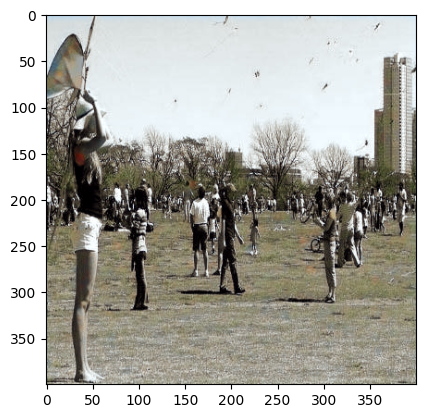

In [101]:
def get_pred(link):
    img = Image.open(link).convert("L")
    img = transform(img)

    res = model.predict(img)
    res = res.squeeze(0)
    res = res.permute(1, 2, 0).to("cpu")
    plt.imshow(res)
    plt.show()

link = "/kaggle/input/image-colorization-dataset/data/test_black/image5020.jpg"
get_pred(link)   

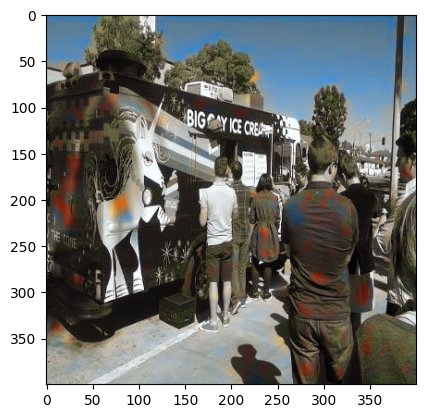

In [102]:
link = "/kaggle/input/image-colorization-dataset/data/test_black/image5040.jpg"
get_pred(link)  

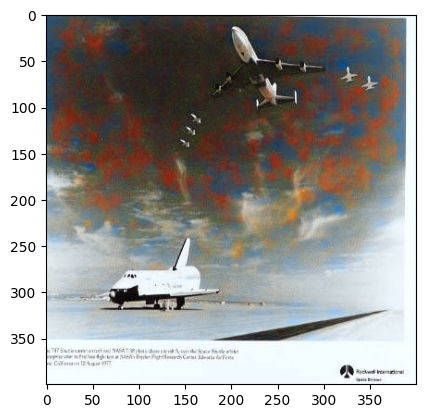

In [103]:
link = f"/kaggle/input/image-colorization-dataset/data/test_black/image5009.jpg"
get_pred(link)  

In [ ]:
link = f"/kaggle/input/image-colorization-dataset/data/test_black/image5009.jpg"
get_pred(link)  

In [157]:
def visualize_all_three(original_images, grayscale_images, colorized_images):
    fig = plt.figure(figsize=(10, 4))
    # for i in range(n):
       
    ax = plt.subplot(1, 3, 1)
    plt.imshow(original_images)
    ax.set_title("Original")
    ax.axis("off")

        
    ax = plt.subplot(1, 3, 2)
    plt.imshow(grayscale_images)
    ax.set_title("Grayscale")
    ax.axis("off")

    ax = plt.subplot(1, 3, 3)
    plt.imshow(colorized_images)
    ax.set_title("Colorized")
    ax.axis("off")

    plt.tight_layout()
    plt.show()

In [135]:
test_dl = DataLoader(test_data, batch_size=1, generator=torch.Generator(device="cpu"))

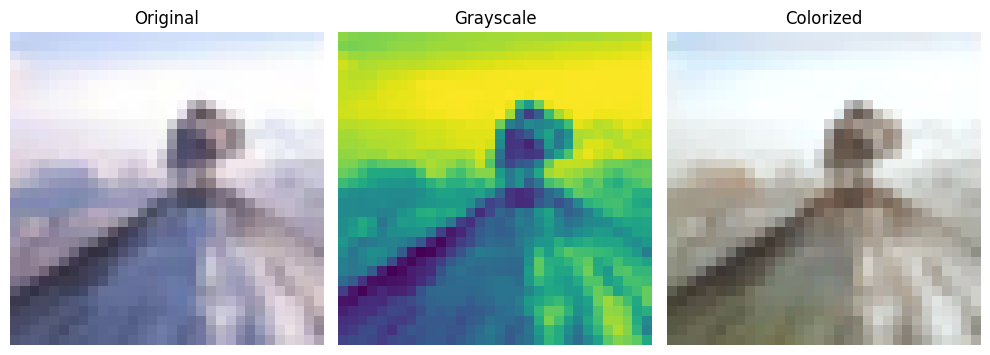

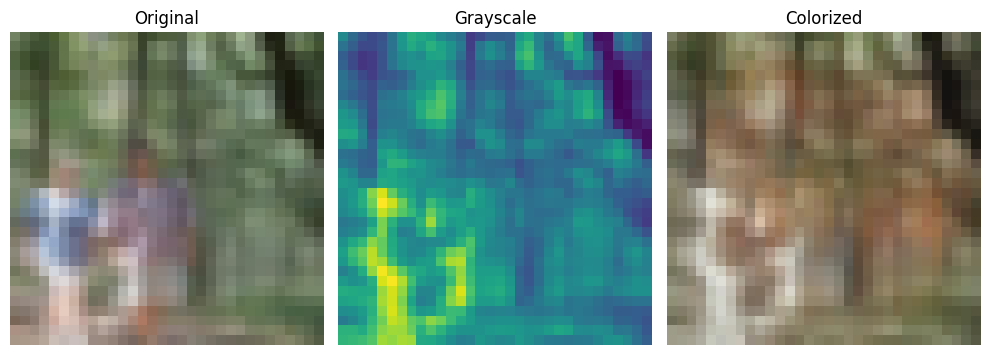

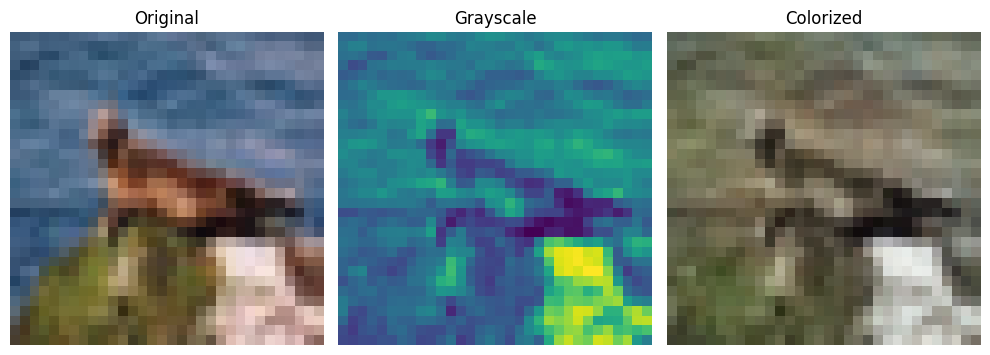

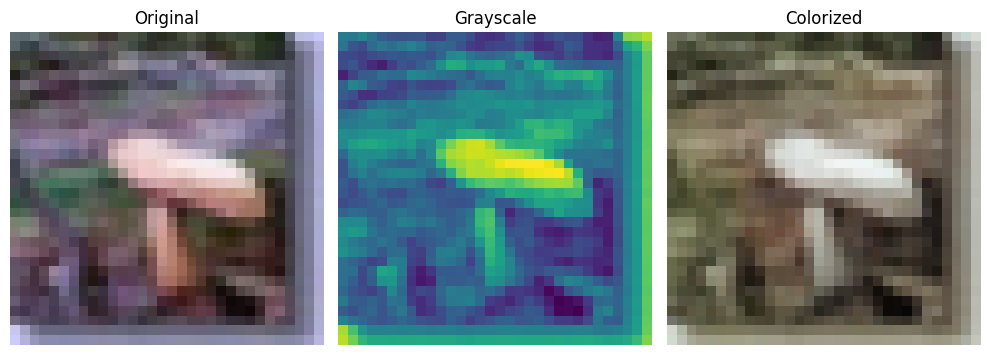

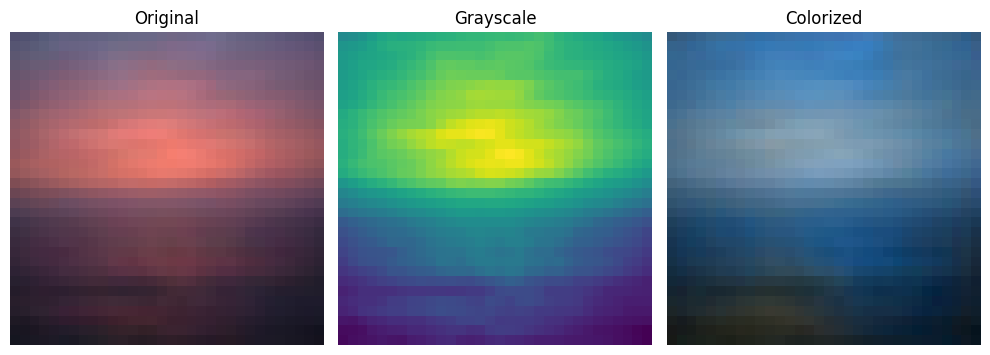

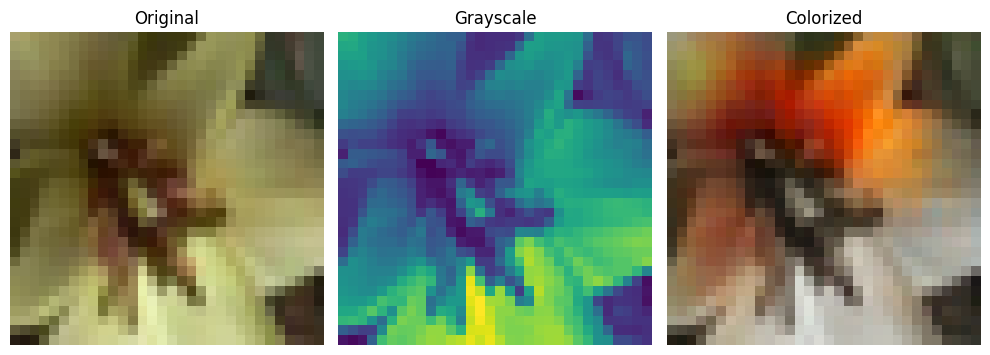

In [160]:
limit = 6
for i, (image, _) in enumerate(test_dl):
    
    gray = rgb_to_gray(image)
    res = model.predict(gray)

    image = image.squeeze(0)
    image_to_display = image.permute(1, 2, 0).cpu().numpy()
    # print(image_to_display.shape)
    
    gray = gray.squeeze(0)
    gray_to_display = gray.permute(1, 2, 0).cpu().numpy()
    # print(gray_to_display.shape)

    res = res.squeeze(0)
    res_to_display = res.permute(1, 2, 0).cpu().numpy()
    # print(res_to_display.shape)

    visualize_all_three(image_to_display, gray_to_display, res_to_display, n=1)

    if i+1 >= limit:
        break


    
    

In [152]:
def show_metric(history, name):
    plt.plot(history[f"train_{name}"], label = "train")
    plt.plot(history[f"val_{name}"], label = "validation")
    plt.xlabel("Epochs")
    plt.ylabel(name.upper())
    plt.legend()
    plt.plot()

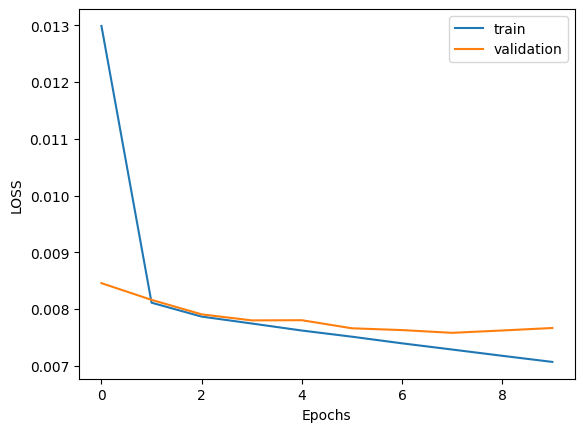

In [153]:
show_metric(history, "loss")

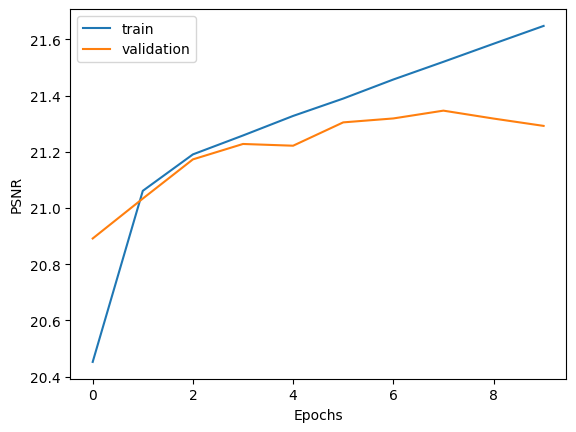

In [154]:
show_metric(history, "psnr")

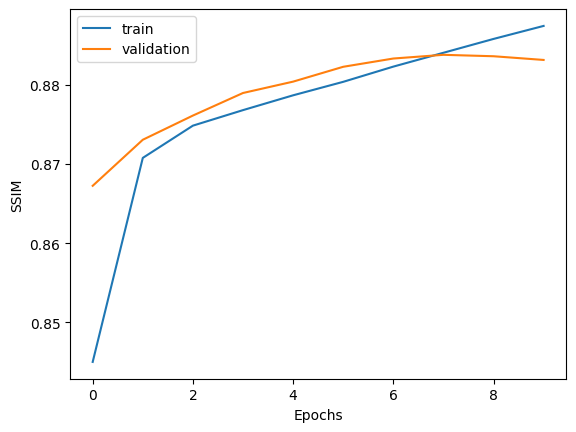

In [156]:
show_metric(history, "ssim")

In [162]:
torch.save(model.state_dict(), "autoencoder_colorizer_v02.pt")

Conclusion: this case shows, that image size is less important feature, when it comes to image colorization. I will implement another colorizer model with other dataset. 